# Time-series prediction (temperature from weather stations)

Companion to [(Time series prediction, end-to-end)](./sinewaves.ipynb), except on a real dataset.

In [1]:
# change these to try this notebook out
BUCKET = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%%datalab project set -p $PROJECT

# Data exploration and cleanup

The data are temperature data from US weather stations. This is a public dataset from NOAA.

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import google.datalab.bigquery as bq
from __future__ import print_function

In [5]:
def query_to_dataframe(year):
  query="""
SELECT
  stationid, date,
  MIN(tmin) AS tmin,
  MAX(tmax) AS tmax,
  IF (MOD(ABS(FARM_FINGERPRINT(stationid)), 10) < 7, True, False) AS is_train
FROM (
  SELECT
    wx.id as stationid,
    wx.date as date,
    CONCAT(wx.id, " ", CAST(wx.date AS STRING)) AS recordid,
    IF (wx.element = 'TMIN', wx.value/10, NULL) AS tmin,
    IF (wx.element = 'TMAX', wx.value/10, NULL) AS tmax
  FROM
    `bigquery-public-data.ghcn_d.ghcnd_{}` AS wx
  WHERE STARTS_WITH(id, 'USW000')
)
GROUP BY
  stationid, date
""".format(year)
  df = bq.Query(query).execute().result().to_dataframe()
  return df

df = query_to_dataframe(2016)
df.head()

,stationid,date,tmin,tmax,is_train
0,USW00003024,2016-03-28,NaN,25.0,True
1,USW00003028,2016-10-13,NaN,NaN,True
2,USW00003029,2016-11-08,NaN,16.7,True
3,USW00003068,2016-07-30,NaN,NaN,False
4,USW00003068,2016-05-14,NaN,NaN,False


In [6]:
df.describe()

,tmin,tmax
count,408241.000000,408271.000000
mean,7.679339,19.674030
std,10.608869,11.435323
min,-57.700000,-35.500000
25%,0.400000,12.200000
50%,8.300000,21.700000
75%,15.800000,28.900000
max,37.600000,51.700000


Unfortunately, there are missing observations on some days.

In [7]:
df.isnull().sum()

stationid        0
date             0
tmin         11316
tmax         11286
is_train         0
dtype: int64

One way to fix this is to do a pivot table and then replace the nulls by filling it with nearest valid neighbor

In [7]:
def cleanup_nulls(df, variablename):
  df2 = df.pivot_table(variablename, 'date', 'stationid', fill_value=np.nan)
  print('Before: {} null values'.format(df2.isnull().sum().sum()))
  df2.fillna(method='ffill', inplace=True)
  df2.fillna(method='bfill', inplace=True)
  df2.dropna(axis=1, inplace=True)
  print('After: {} null values'.format(df2.isnull().sum().sum()))
  return df2

In [9]:
traindf = cleanup_nulls(df[df['is_train']], 'tmin')

Before: 14986 null values
After: 0 null values


In [10]:
traindf.head()

stationid,USW00003016,USW00003017,USW00003024,USW00003026,USW00003028,USW00003029,USW00003030,USW00003031,USW00003032,USW00003048,...,USW00094990,USW00094991,USW00094992,USW00094993,USW00094994,USW00094995,USW00094996,USW00096404,USW00096407,USW00096408
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,-22.1,-14.3,-6.6,-14.3,-14.9,-12.7,-9.9,-1.0,4.4,-3.2,...,-7.7,-9.3,-8.2,-8.2,-7.1,-8.9,-9.3,-17.4,-3.0,-7.0
2016-01-02,-21.0,-8.8,-4.9,-12.7,-10.5,-13.8,-8.2,0.6,3.9,-7.8,...,-6.6,-9.9,-4.9,-8.2,-10.5,-10.2,-7.9,-19.5,-3.0,-7.0
2016-01-03,-17.1,-9.3,-3.8,-10.5,-8.8,-13.2,-5.5,-1.0,2.2,-10.0,...,-11.0,-7.1,-7.1,-13.2,-10.5,-9.5,-9.5,-16.0,-3.0,-7.0
2016-01-04,-14.3,-7.7,-5.5,-8.2,-9.3,-7.1,-9.3,-2.1,1.1,-7.9,...,-8.8,-7.1,-9.9,-16.6,-13.2,-8.6,-9.5,-24.0,-3.2,-7.0
2016-01-05,-11.0,-4.9,-2.1,-7.1,-6.6,-2.7,-3.2,1.1,5.6,-1.1,...,-6.0,-7.7,-2.1,-6.6,-16.0,-7.5,-6.3,-28.0,-3.2,-7.0


366 values in the sequence


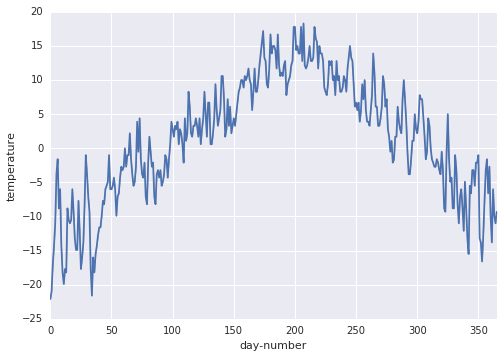

In [11]:
seq = traindf.iloc[:,0]
print('{} values in the sequence'.format(len(seq)))
ax = sns.tsplot(seq)
ax.set(xlabel='day-number', ylabel='temperature');

In [13]:
seq.to_string(index=False).replace('\n', ',')

u'date,-22.1,-21.0,-17.1,-14.3,-11.0,-3.8,-1.6,-8.8,-6.0,-14.3,-18.2,-19.9,-17.7,-18.2,-8.8,-10.5,-11.0,-10.5,-6.0,-9.3,-13.2,-14.9,-14.9,-7.7,-12.1,-17.7,-16.0,-13.8,-8.2,-1.0,-3.8,-7.1,-9.3,-17.7,-21.6,-16.0,-18.2,-15.5,-14.3,-12.7,-11.6,-11.6,-9.9,-7.7,-8.2,-6.0,-5.5,-4.9,-1.0,-6.0,-6.0,-5.5,-4.3,-6.0,-9.9,-7.1,-6.6,-4.3,-2.7,-3.2,-2.7, 0.0,-2.7,-1.0,-1.0, 2.2,-1.6,-3.8,-5.5,-4.9,-2.7, 3.9,-0.5, 4.4,-1.6,-3.8,-4.3,-2.1,-7.1,-8.2,-2.1, 1.7,-0.5,-2.7,-2.1,-7.1,-8.2,-3.8,-3.2,-4.3,-3.2,-5.5,-4.9,-3.8,-1.0,-1.6,-4.3,-1.6, 0.6, 3.9, 2.8, 1.7, 3.3, 2.8, 3.9, 0.6, 2.8, 2.2, 0.6,-2.1, 4.4, 1.1, 2.2, 8.3, 6.1, 2.2, 1.7, 3.3, 3.3, 4.4, 3.3, 1.7, 4.4, 0.6, 2.8, 4.4, 8.3, 5.0, 1.7, 6.7, 6.7, 0.6, 0.6, 2.2, 4.4, 9.4, 5.6, 3.3, 4.4, 5.6,10.6,10.6, 7.2, 1.7, 2.8, 7.2, 3.3, 6.1, 2.2, 3.3, 4.4, 3.3, 5.0, 6.7, 8.3, 8.9,10.0,10.0, 8.9,10.6,10.0,10.6,11.7,10.0, 9.4, 5.6, 8.3,11.7, 8.3, 8.3,10.0,12.2,13.9,15.6,17.2,13.3,12.8, 9.4, 8.9,11.7,16.7,13.9,15.0,15.0,14.4,11.7,16.7,12.2,10.6,11.1,10.6,12.2,12.8

In [ ]:
# Save the data to disk in such a way that each time series is on a single line
# save to sharded files, one for each year
# This takes about 15 minutes
import shutil, os
shutil.rmtree('data/temperature', ignore_errors=True)
os.makedirs('data/temperature')

def to_csv(indf, filename):
  df = cleanup_nulls(indf, 'tmin')
  print('Writing {} sequences to {}'.format(len(df.columns), filename))
  with open(filename, 'w') as ofp:
    for i in xrange(0, len(df.columns)):
      if i%10 == 0:
        print('{}'.format(i), end='...')
      seq = df.iloc[:365,i]  # chop to 365 days to avoid leap-year problems ...
      line = seq.to_string(index=False, header=False).replace('\n', ',')
      ofp.write(line + '\n')
    print('Done')

for year in xrange(2000, 2017):
  print('Querying data for {} ... hang on'.format(year))
  df = query_to_dataframe(year)
  to_csv(df[df['is_train']], 'data/temperature/train-{}.csv'.format(year))
  to_csv(df[~df['is_train']], 'data/temperature/eval-{}.csv'.format(year))

In [ ]:
%bash
head -1 data/temperature/eval-2004.csv | tr ',' ' ' | wc
head -1 data/temperature/eval-2005.csv | tr ',' ' ' | wc
wc -l data/temperature/train*.csv
wc -l data/temperature/eval*.csv

In [ ]:
%bash
gsutil -m rm -rf gs://${BUCKET}/temperature/*
gsutil -m cp data/temperature/*.csv gs://${BUCKET}/temperature

Our CSV file sequences consist of 365 values. For training, each instance's 0~364 numbers are inputs, and 365th is truth.

# Model

This is the same model as [(Time series prediction, end-to-end)](./sinewaves.ipynb)


In [ ]:
%bash
#for MODEL in dnn; do
for MODEL in cnn dnn lstm lstm2 lstmN; do
  OUTDIR=gs://${BUCKET}/temperature/$MODEL
  JOBNAME=temperature_${MODEL}_$(date -u +%y%m%d_%H%M%S)
  REGION=us-central1
  gsutil -m rm -rf $OUTDIR
  gcloud ml-engine jobs submit training $JOBNAME \
     --region=$REGION \
     --module-name=trainer.task \
     --package-path=${PWD}/sinemodel/trainer \
     --job-dir=$OUTDIR \
     --staging-bucket=gs://$BUCKET \
     --scale-tier=BASIC_GPU \
     --runtime-version=1.2 \
     -- \
     --train_data_paths="gs://${BUCKET}/temperature/train*.csv" \
     --eval_data_paths="gs://${BUCKET}/temperature/eval*.csv"  \
     --output_dir=$OUTDIR \
     --train_steps=5000 --sequence_length=365 --model=$MODEL
done

## Results

When I ran it, these were the RMSEs that I got for different models:

| Model | # of steps | Minutes | RMSE |
| --- | ----| --- | --- | --- |
| dnn | 5000 | 19 min | 9.82 |
| cnn | 5000 | 22 min | 6.68 |
| lstm | 5000 | 41 min | 3.15 |
| lstm2 | 5000 | 107 min | 3.91 |
| lstmN | 5000 | 107 min | 11.5 |

As you can see, on real-world time-series data, LSTMs can really shine, but the highly tuned version for the synthetic data doesn't work as well on a similiar, but different problem. Instead, we'll probably have to retune ...

<p>
## Next steps
This is likely not the best way to formulate this problem. A better method to work with this data would be to pull out arbitrary, shorter sequences (say of length 20) from the input sequences. This would be akin to image augmentation in that we would get arbitrary subsets, and would allow us to predict the sequence based on just the last 20 values instead of requiring a whole year.  It would also avoid the problem that currently, we are training only for Dec. 30/31.

Feature engineering would also help. For example, we might also add a climatological average (average temperature at this location over the last 10 years on this date) as one of the inputs. I'll leave both these improvements as exercises for the reader :)

Copyright 2017 Google Inc. Licensed under the Apache License, Version 2.0 (the \"License\"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an \"AS IS\" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License